In [39]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../src/')
from diffusion import DiffusionModel
from evaluate import get_results
from omegaconf import OmegaConf
from main import load_data, make_model
import numpy as np
import os
import glob
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import torch
from model import AEDist
import magic
import torch

In [40]:
# Initialize wandb (replace 'your_entity' and 'your_project' with your specific details)
wandb.login()
api = wandb.Api()

# Specify your entity, project, and sweep ID
entity = "xingzhis"
project = "dmae"
sweep_id = 'n7y31c3j'

# Fetch the sweep
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

run_ids = [run.id for run in sweep.runs]

# run_id = 'xdhzzu52'
run_id = 'ul62h5ux'
run = [run for run in sweep.runs if run.id == run_id][0]

In [41]:
cfg = OmegaConf.create(run.config)
folder_path = "../src/wandb/"
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]

In [42]:
cfg.layer_widths

[64, 128, 256]

In [43]:
diffusionmodel = DiffusionModel.load_from_checkpoint(
    checkpoint_path=ckpt_path,
)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


In [44]:
diffusionmodel.network

MLP(
  (net): Sequential(
    (0): Linear(in_features=18, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [45]:
dat = np.load('../dm_data/sea_ad_all_new_2.npz')

In [46]:
dat['data'].shape

(3785, 2)

In [47]:
# data_pred = x_pred[~train_mask]
# latent_pred = z_pred[~train_mask]
train_mask = dat['train_mask']
with torch.no_grad():
    generated_latent = diffusionmodel.generate_samples((~train_mask).sum())

In [48]:
generated_latent.shape

torch.Size([757, 2])

In [49]:
data_latent = np.load(cfg.path + cfg.data)
data_latent_train = data_latent['data'][data_latent['train_mask']]
mean_, std_ = np.mean(data_latent_train, axis=0), np.std(data_latent_train, axis=0)

In [50]:
mean_

array([  4.6213384, -13.735345 ], dtype=float32)

In [51]:
std_

array([131.39326,  99.71539], dtype=float32)

In [52]:
generated_latent.size()

torch.Size([757, 2])

In [53]:
generated_latent = generated_latent * std_ + mean_

In [54]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot

In [55]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
latent_gen = generated_latent.detach().cpu().numpy()
latent_test = data_latent['data'][~data_latent['train_mask']]
latent_train = data_latent['data'][data_latent['train_mask']]

In [57]:
def compute_w2(gen, tru):
    M = ot.dist(gen, tru)
    M = torch.tensor(M, dtype=torch.float32, device=device)
    # M/=M.max()
    n = latent_test.shape[0]
    a, b = torch.ones((n,)).to(device) / n, torch.ones((n,)).to(device) / n  # uniform distribution on samples
    G0 = ot.emd(a, b, M)
    W = torch.sum(G0 * M)
    return torch.sqrt(W)

In [58]:
std = latent_train.std()
noises = np.arange(1, 10) * 0.1
w2s = []
for noise in noises:
    noisy_test = latent_test + np.random.randn(*latent_test.shape) * noise * std
    w2 = compute_w2(noisy_test, latent_test).detach().cpu().numpy()
    w2s.append(w2)

In [59]:
mean = latent_train.mean(axis=0)
cov = np.cov(latent_train, rowvar=False)
rand_samples = np.random.multivariate_normal(mean, cov, latent_test.shape[0])

In [60]:
res = np.array([noises, w2s]).T
w_rand = compute_w2(rand_samples, latent_test).cpu().numpy()
w_gen = compute_w2(latent_gen, latent_test).cpu().numpy()

In [61]:
np.random.seed(42)
latent_train_subset_id = np.random.choice(np.arange(len(latent_train)), size=len(latent_test), replace=False)
latent_train_subset = latent_train[latent_train_subset_id]
w_train = compute_w2(latent_train_subset, latent_test).cpu().numpy()

Text(0, 0.5, 'w2')

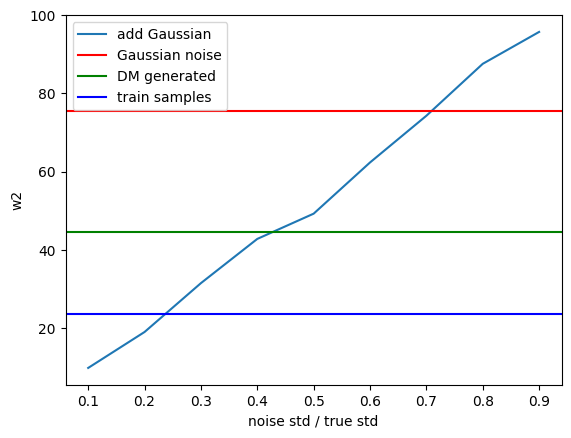

In [62]:
fig, ax = plt.subplots()
ax.plot(res[:,0], res[:,1], label='add Gaussian')
ax.axhline(y=w_rand, color='r', linestyle='-', label='Gaussian noise')
ax.axhline(y=w_gen, color='g', linestyle='-', label='DM generated')
ax.axhline(y=w_train, color='b', linestyle='-', label='train samples')
# ax.axhline(y=w_permu, color='y', linestyle='-', label='permuted samples')
ax.legend()
ax.set_xlabel('noise std / true std')
ax.set_ylabel('w2')

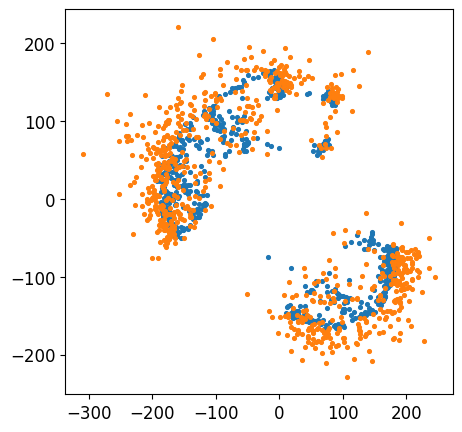

In [63]:
# make two subplots side by side
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
scprep.plot.scatter2d(latent_test, ax=axes)
scprep.plot.scatter2d(generated_latent.cpu().numpy(), ax=axes)
plt.show()

In [64]:
# Initialize wandb (replace 'your_entity' and 'your_project' with your specific details)
wandb.login()
api = wandb.Api()

# Specify your entity, project, and sweep ID
entity = "xingzhis"
project = "dmae"
sweep_id = '9qr8zqxg'

# Fetch the sweep
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

run_ids = [run.id for run in sweep.runs]
run_id = 'rw7xfrhb'
run = [run for run in sweep.runs if run.id == run_id][0]
cfg = OmegaConf.create(run.config)
folder_path = "../src/wandb/"
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
data_path = os.path.join(cfg.data.root, cfg.data.name + cfg.data.filetype)
data = np.load(data_path, allow_pickle=True)
# model = AEDist(dim=50, emb_dim=10)
# model.load_from_checkpoint(ckpt_path)
model = AEDist.load_from_checkpoint(ckpt_path)
model.eval()
# x_all = torch.tensor(data['data'], dtype=torch.float32)
# x_pred, z_pred = model(x_all)
# x_pred = x_pred.detach().cpu().numpy()
# z_pred = z_pred.detach().cpu().numpy()

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:281: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mean', torch.tensor(mean, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('std', torch.tensor(std, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore t

AEDist(
  (encoder): MLP(
    (net): Sequential(
      (0): Linear(in_features=100, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=64, bias=True)
      (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Linear(in_features=64, out_features=2, bias=True)
    )
  )
  (decoder): MLP(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [65]:
model.eval()
with torch.no_grad():
    gen_decoded = model.decode(generated_latent)

In [66]:
model.eval()
with torch.no_grad():
    test_decoded = model.decode(torch.tensor(latent_test, dtype=torch.float32))

In [67]:
gen_decoded.shape

torch.Size([757, 100])

In [68]:
test_ambient = data['data'][~data['is_train']]
test_ambient = torch.tensor(test_ambient, dtype=torch.float)
train_ambient = data['data'][data['is_train']]
train_ambient = torch.tensor(train_ambient, dtype=torch.float)

In [69]:
w_gen = compute_w2(gen_decoded, test_ambient)

/tmp/tmp.PMigNVAsjz/ipykernel_1352453/1789824827.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  M = torch.tensor(M, dtype=torch.float32, device=device)


In [70]:
# std = train_ambient.std()
# noises = np.arange(1, 10) * 0.1
# w2s = []
# for noise in noises:
#     noisy_test = test_ambient + torch.tensor(np.random.randn(*test_ambient.shape), dtype=torch.float32) * noise * std
#     w2 = compute_w2(noisy_test, test_ambient).detach().cpu().numpy()
#     w2s.append(w2)
# res = np.array([noises, w2s]).T

# mean = train_ambient.mean(axis=0)
# cov = np.cov(train_ambient, rowvar=False)
# rand_samples = np.random.multivariate_normal(mean, cov, test_ambient.shape[0])
# rand_samples = torch.tensor(rand_samples, dtype=torch.float32)
# w_rand = compute_w2(rand_samples, test_ambient).cpu().numpy()

# np.random.seed(42)
# train_ambient_subset_id = np.random.choice(np.arange(len(train_ambient)), size=len(test_ambient), replace=False)
# train_ambient_subset = train_ambient[train_ambient_subset_id]
# w_train = compute_w2(train_ambient_subset, test_ambient).cpu().numpy()


In [71]:
# fig, ax = plt.subplots()
# ax.plot(res[:,0], res[:,1], label='add Gaussian')
# ax.axhline(y=w_rand, color='r', linestyle='-', label='Gaussian noise')
# ax.axhline(y=w_gen.cpu().numpy(), color='g', linestyle='-', label='DM generated')
# ax.axhline(y=w_train, color='b', linestyle='-', label='train samples')
# # ax.axhline(y=w_permu.cpu().numpy(), color='y', linestyle='-', label='permuted samples')
# ax.legend()
# ax.set_xlabel('noise std / true std')
# ax.set_ylabel('w2')

In [72]:
magic_op = magic.MAGIC()
x_magic = magic_op.fit_transform(test_ambient.cpu().numpy())

Calculating MAGIC...
  Running MAGIC on 757 cells and 100 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
    Calculated affinities in 0.07 seconds.
  Calculated graph and diffusion operator in 0.14 seconds.
  Calculating imputation...
Calculated MAGIC in 0.15 seconds.


In [73]:
pc_data = np.load('../data/sea_ad_all_pcs_correct.npz')
pca_loadings = pc_data['pca_loadings'].T
data_mean = pc_data['data_mean']

In [74]:
pca_data = x_magic
orig_magic = np.dot(pca_data, pca_loadings.T) + data_mean
orig_magic = np.asarray(orig_magic)
orig_magic = torch.tensor(orig_magic, dtype=torch.float32)

In [75]:
pca_data = gen_decoded.cpu().numpy()
orig_gen = np.dot(pca_data, pca_loadings.T) + data_mean
orig_gen = np.asarray(orig_gen)
orig_gen = torch.tensor(orig_gen, dtype=torch.float32)

In [76]:
pca_data = train_ambient.cpu().numpy()
orig_train = np.dot(pca_data, pca_loadings.T) + data_mean
orig_train = np.asarray(orig_train)
orig_train = torch.tensor(orig_train, dtype=torch.float32)

In [77]:
pca_data = test_decoded.cpu().numpy()
orig_dec = np.dot(pca_data, pca_loadings.T) + data_mean
orig_dec = np.asarray(orig_dec)
orig_dec = torch.tensor(orig_dec, dtype=torch.float32)

In [78]:
# std = orig_train.std()
# noises = np.arange(1, 10) * 0.1
# w2s = []
# for noise in noises:
#     noisy_test = orig_magic + torch.tensor(np.random.randn(*orig_magic.shape), dtype=torch.float32) * noise * std
#     w2 = compute_w2(noisy_test, orig_magic).detach().cpu().numpy()
#     w2s.append(w2)
# res = np.array([noises, w2s]).T

# mean = orig_magic.mean(axis=0)
# cov = np.cov(orig_magic, rowvar=False)
# rand_samples = np.random.multivariate_normal(mean, cov, orig_magic.shape[0])
# rand_samples = torch.tensor(rand_samples, dtype=torch.float32)
# w_rand = compute_w2(rand_samples, orig_magic).cpu().numpy()

# np.random.seed(42)
# orig_train_subset_id = np.random.choice(np.arange(len(orig_train)), size=len(orig_magic), replace=False)
# orig_train_subset = orig_train[orig_train_subset_id]
# w_train = compute_w2(orig_train_subset, orig_magic).cpu().numpy()


In [79]:
# fig, ax = plt.subplots()
# ax.plot(res[:,0], res[:,1], label='add Gaussian')
# ax.axhline(y=w_rand, color='r', linestyle='-', label='Gaussian noise')
# ax.axhline(y=w_gen.cpu().numpy(), color='g', linestyle='-', label='DM generated')
# ax.axhline(y=w_train, color='b', linestyle='-', label='train samples')
# # ax.axhline(y=w_permu.cpu().numpy(), color='y', linestyle='-', label='permuted samples')
# ax.legend()
# ax.set_xlabel('noise std / true std')
# ax.set_ylabel('w2')

In [80]:
orig_vars = orig_magic.var(axis=0)
top_100_idx = torch.argsort(orig_vars).flip(0)[:10000]

In [81]:
magic_top100 = orig_magic[:,top_100_idx].cpu().numpy()
gen_top100 = orig_gen[:,top_100_idx].cpu().numpy()
dec_top100 = orig_dec[:,top_100_idx].cpu().numpy()

In [82]:
corrs_magic = np.corrcoef(magic_top100, rowvar=False)
corrs_gen = np.corrcoef(gen_top100, rowvar=False) 
corrs_dec = np.corrcoef(dec_top100, rowvar=False)

In [83]:
((corrs_magic - corrs_gen)**2).mean()

0.14745146225817934

In [84]:
((corrs_magic - corrs_dec)**2).mean()

0.012923142303276406

In [85]:
corrs_gen.shape

(3515, 3515)

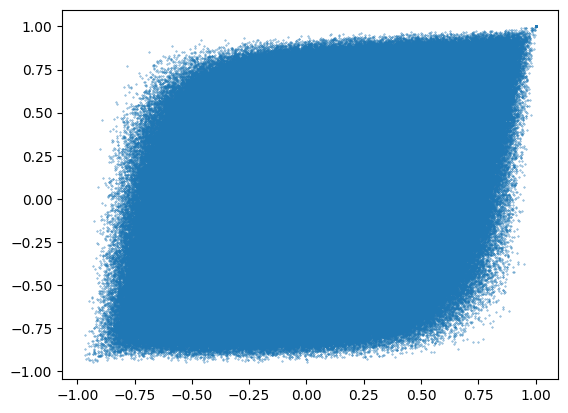

In [86]:
plt.scatter(corrs_magic.flatten(), corrs_gen.flatten(), s=.1, alpha=.5)
plt.show()

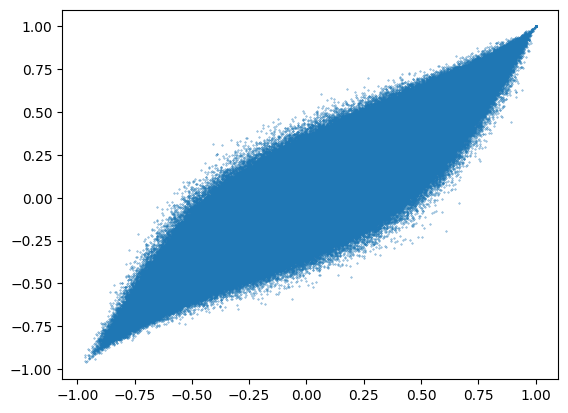

In [87]:
plt.scatter(corrs_magic.flatten(), corrs_dec.flatten(), s=.1, alpha=.5)
plt.show()

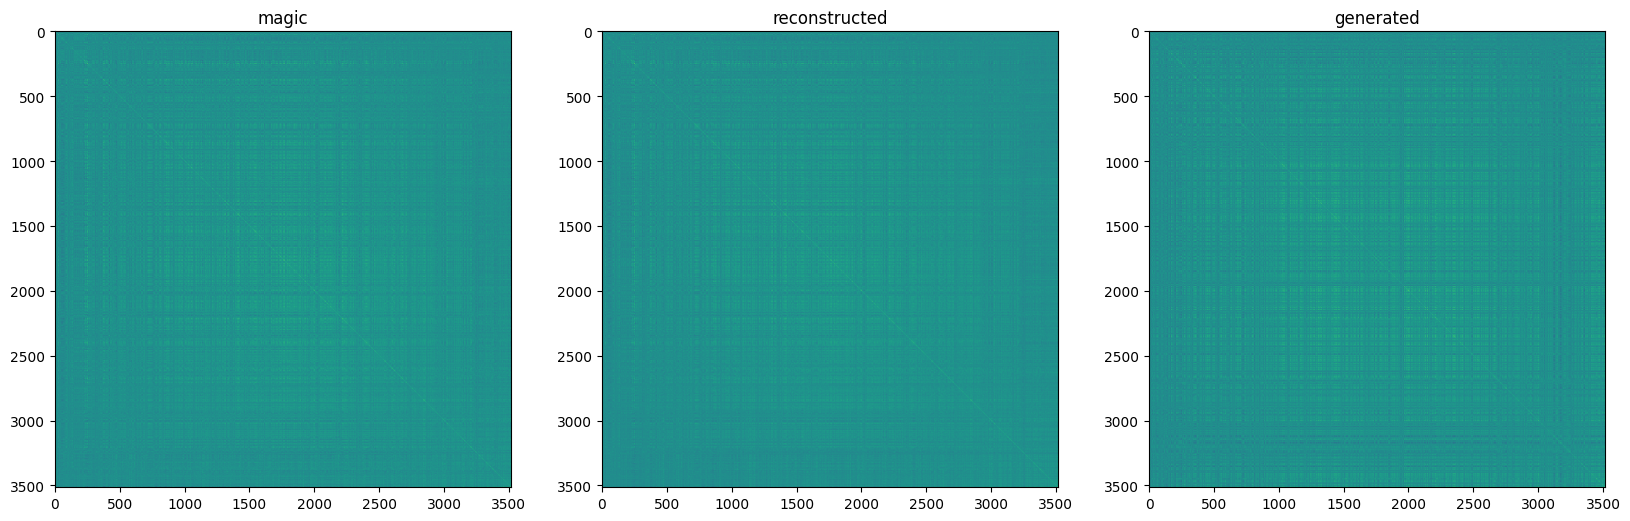

In [88]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(corrs_magic)
plt.title('magic')
plt.subplot(1, 3, 2)
plt.imshow(corrs_dec)
plt.title('reconstructed')
plt.subplot(1, 3, 3)
plt.imshow(corrs_gen)
plt.title('generated')
plt.show()

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: >

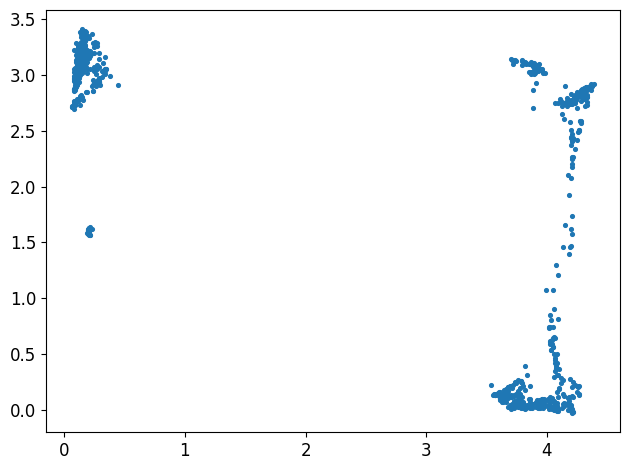

In [89]:
scprep.plot.scatter2d(magic_top100)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: >

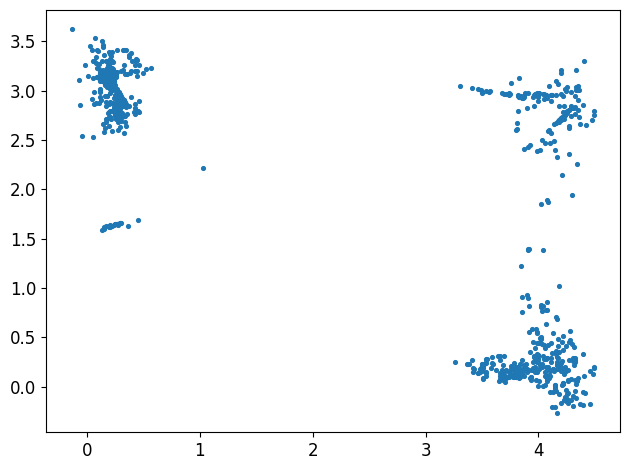

In [90]:
scprep.plot.scatter2d(dec_top100)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: >

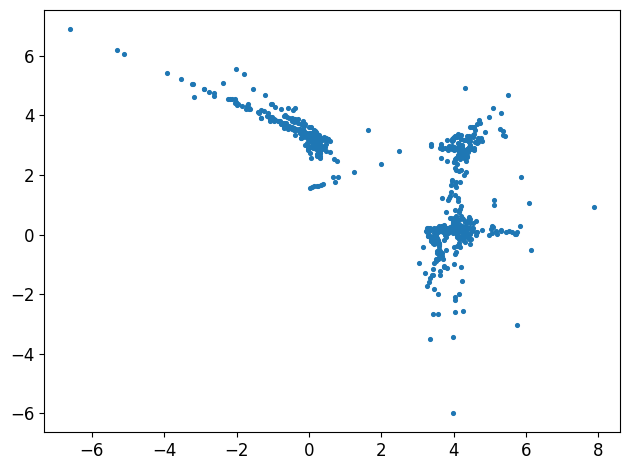

In [91]:
scprep.plot.scatter2d(gen_top100)